# DESI Redshift Catalogs

This notebook shows a worked example of reading a DESI redshift catalog
and making n(z) histograms for each target class.

In [1]:
# Python and external package imports
import os
import numpy as np

import fitsio
from astropy.table import Table
import matplotlib.pyplot as plt

In [2]:
# DESI-specific imports
from desitarget.targets import desi_mask

Remember from `02_DataOrganization.ipynb`, we will define the spectroscopic production directory at the top to make it easier to switch to other productions in the future.

In [3]:
specprod = 'loa'    # production name for the final Year 3 (Y3) production
desi_root = os.environ['DESI_ROOT']
desi_root_ro = os.environ['DESI_ROOT_READONLY']
specprod_dir = f'{desi_root_ro}/spectro/redux/{specprod}'
print(specprod_dir)

/dvs_ro/cfs/cdirs/desi/spectro/redux/loa


What redshift catalog files are available?

In [4]:
sorted(os.listdir(f'{specprod_dir}/zcatalog/v1'))

['logs',
 'redux_loa_zcatalog_v1.sha256sum',
 'zall-pix-loa.fits',
 'zall-tilecumulative-loa.fits',
 'zpix-cmx-other.fits',
 'zpix-main-backup.fits',
 'zpix-main-bright.fits',
 'zpix-main-dark.fits',
 'zpix-special-backup.fits',
 'zpix-special-bright.fits',
 'zpix-special-dark.fits',
 'zpix-sv1-backup.fits',
 'zpix-sv1-bright.fits',
 'zpix-sv1-dark.fits',
 'zpix-sv1-other.fits',
 'zpix-sv2-backup.fits',
 'zpix-sv2-bright.fits',
 'zpix-sv2-dark.fits',
 'zpix-sv3-backup.fits',
 'zpix-sv3-bright.fits',
 'zpix-sv3-dark.fits',
 'ztile-cmx-other-cumulative.fits',
 'ztile-main-backup-cumulative.fits',
 'ztile-main-bright-cumulative.fits',
 'ztile-main-dark-cumulative.fits',
 'ztile-special-backup-cumulative.fits',
 'ztile-special-bright-cumulative.fits',
 'ztile-special-dark-cumulative.fits',
 'ztile-sv1-backup-cumulative.fits',
 'ztile-sv1-bright-cumulative.fits',
 'ztile-sv1-dark-cumulative.fits',
 'ztile-sv1-other-cumulative.fits',
 'ztile-sv2-backup-cumulative.fits',
 'ztile-sv2-bright-cu

For this notebook, we'll use the `zall-pix-{specprod}.fits` file.

This file is huge: 48GB in Loa, with 137 columns and 64 million rows.  It is *not* viable to read this with `astropy.table.Table.read` or `astropy.io.fits.read`, since that will blow memory for the Jupyter server if everyone does that.  Instead, see the [datamodel](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html#hdu1) for what different columns are available, and use `fitsio` to read just the ones you want.

Even this can take several minutes.

In [5]:
columns = ('TARGETID', 'SURVEY', 'PROGRAM', 'DESI_TARGET', 'Z', 'COADD_FIBERSTATUS', 'ZWARN', 'DELTACHI2', 'MAIN_PRIMARY')
zall_file = f'{specprod_dir}/zcatalog/v1/zall-pix-{specprod}.fits'
print(f'Reading {zall_file}')
%time zcat = fitsio.read(zall_file, 'ZCATALOG', columns=columns)

Reading /dvs_ro/cfs/cdirs/desi/spectro/redux/loa/zcatalog/v1/zall-pix-loa.fits
CPU times: user 37.9 s, sys: 1min 17s, total: 1min 54s
Wall time: 7min 19s


In [6]:
print(f'{os.path.basename(zall_file)} has {len(zcat)} targets')

zall-pix-loa.fits has 64100684 targets


In [7]:
# filter to just main survey targets
keep = zcat['SURVEY'] == 'main'

# additionally filter by
#   good hardware (COADD_FIBERSTATUS=0)
#   good redshift fits (ZWARN=0)
#   higher confidence redshift fits (DELTACHI2>25)
keep &= zcat['COADD_FIBERSTATUS'] == 0
keep &= zcat['ZWARN'] == 0
keep &= zcat['DELTACHI2'] > 25

nkeep = np.sum(keep)
print(f'Keeping {nkeep}/{len(zcat)} targets')

zcat = zcat[keep]

Keeping 43802945/64100684 targets


Now well use the `DESI_TARGET` column to select which targets are ELG, LRG, etc.

See https://github.com/desihub/desitarget/blob/main/doc/nb/target-selection-bits-and-bitmasks.ipynb
for a tutorial going into more details about target selection masks.

In [8]:
isBGS = (zcat['DESI_TARGET'] & desi_mask.BGS_ANY) != 0
isLRG = (zcat['DESI_TARGET'] & desi_mask.LRG) != 0
isELG = (zcat['DESI_TARGET'] & desi_mask.ELG) != 0
isQSO = (zcat['DESI_TARGET'] & desi_mask.QSO) != 0
# apologies to MWS stars; they don't fit well on n(z) histograms with other targets...

Text(0, 0.5, 'QSO')

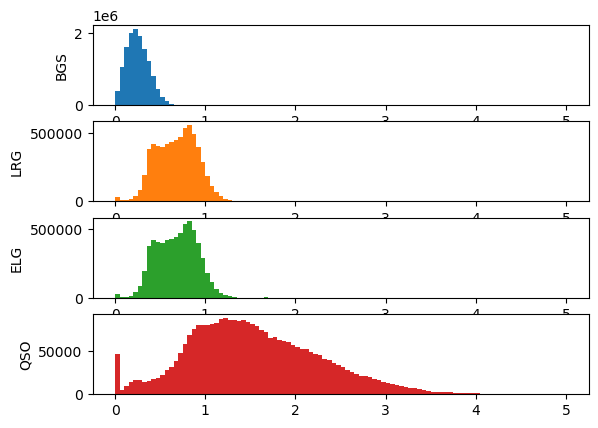

In [9]:
plt.subplot(411)
plt.hist(zcat['Z'][isBGS], 100, (0,5), color='C0')
plt.ylabel('BGS')

plt.subplot(412)
plt.hist(zcat['Z'][isLRG], 100, (0,5), color='C1')
plt.ylabel('LRG')

plt.subplot(413)
plt.hist(zcat['Z'][isLRG], 100, (0,5), color='C2')
plt.ylabel('ELG')

plt.subplot(414)
plt.hist(zcat['Z'][isQSO], 100, (0,5), color='C3')
plt.ylabel('QSO')

## Alternatives

You may have noticed that these files are inconveniently large.  Some alternatives:

  * The redshift catalogs are also loaded into a database.  See https://github.com/desihub/tutorials/blob/main/database/spectroscopic-production-database.ipynb for the basic concepts, though that tutorial has not yet been updated for Y3 analysis with Loa.
  * NOIRLab provides database and web API access for public releases (need link)